[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

## 0. Preperation

- Install latest version of SAHI and ultralytics:

In [1]:
!pip install -U torch sahi ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 43.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=25bb534d8497b1959a180a8f2a8b9f75e2cea01cdc63c2b02c080ee177ab47dc
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [2]:
import os
#os.getcwd()

- Import required modules:

In [3]:
# arrange an instance segmentation model for test
from sahi.utils.ultralytics import (
    download_yolo11n_model, download_yolo11n_seg_model,
    # download_yolov8n_model, download_yolov8n_seg_model
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NqjtCN1BkDxTg2u1jXzs")
project = rf.workspace("liangyu-wu").project("oil-tanks-more")
version = project.version(3)
dataset = version.download("yolov11")



mkdir: cannot create directory ‘{HOME}/datasets’: No such file or directory
[Errno 2] No such file or directory: '{HOME}/datasets'
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Oil-Tanks-More-3 in yolov11:: 100%|██████████| 56/56 [00:00<00:00, 8034.52it/s]


In [5]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

In [6]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True


[Errno 2] No such file or directory: '{HOME}'
/content
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 18.4M/18.4M [00:00<00:00, 132MB/s] 
Ultralytics 8.3.61 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Oil-Tanks-More-3/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ra

- Download a yolov8 model and two test images:

In [8]:
yolo11n_model_path = "runs/detect/train/weights/last.pt"
download_yolo11n_model(yolo11n_model_path)
# yolov8n_model_path = "models/yolov8n.pt"
# download_yolov8n_model(yolov8n_model_path)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a YOLOv8/YOLO11 Model

- Instantiate a detection model by defining model weight path and other parameters:

In [9]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='ultralytics', # or 'yolov8'
    model_path=yolo11n_model_path,
    confidence_threshold=0.3,
    device="cpu", # or 'cuda:0'
)

- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [22]:
result = get_prediction("/content/unnamed (4).png", detection_model)

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [23]:
result = get_prediction(read_image("/content/unnamed (4).png"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

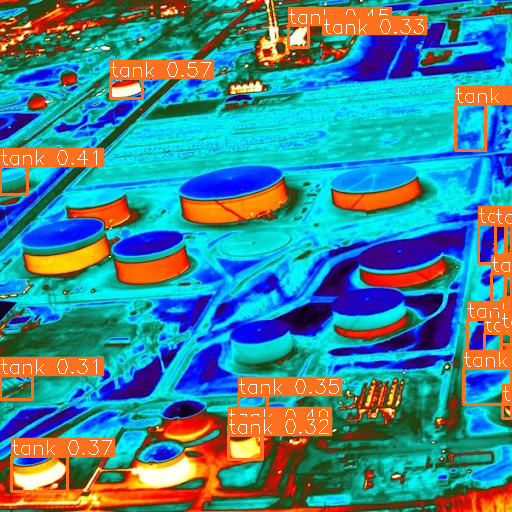

In [24]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a YOLOv8/YOLO11 Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.2:

In [ ]:
result = get_sliced_prediction(
    "Oil-Tanks-More-3/test/images/Cushing3_png.rf.d785759393b002d4eb653de0ad041b5b.jpg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 4 slices.


- Visualize predicted bounding boxes and masks over the original image:

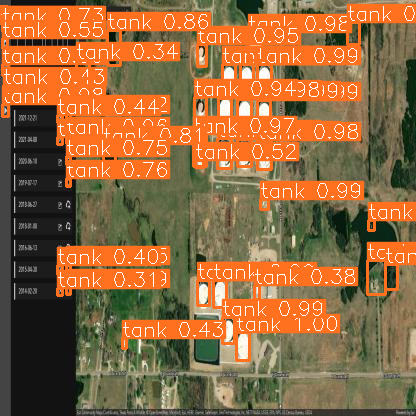

In [ ]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [ ]:
object_prediction_list = result.object_prediction_list

In [ ]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(0.9853302240371704, 6.479804992675781, 7.726264953613281, 16.2401065826416), w: 6.740934729576111, h: 9.76030158996582>,
    mask: None,
    score: PredictionScore: <value: 0.9986410737037659>,
    category: Category: <id: 2, name: tank>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [ ]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [0.9853302240371704,
   6.479804992675781,
   6.740934729576111,
   9.76030158996582],
  'score': 0.9986410737037659,
  'category_id': 2,
  'category_name': 'tank',
  'segmentation': [],
  'iscrowd': 0,
  'area': 65},
 {'image_id': None,
  'bbox': [236.27890014648438,
   332.5246887207031,
   12.958213806152344,
   28.342071533203125],
  'score': 0.9966928958892822,
  'category_id': 2,
  'category_name': 'tank',
  'segmentation': [],
  'iscrowd': 0,
  'area': 367},
 {'image_id': None,
  'bbox': [240.08673095703125,
   64.44107818603516,
   13.101119995117188,
   27.082366943359375],
  'score': 0.9962286949157715,
  'category_id': 2,
  'category_name': 'tank',
  'segmentation': [],
  'iscrowd': 0,
  'area': 354}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [ ]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [0.9853302240371704,
   6.479804992675781,
   6.740934729576111,
   9.76030158996582],
  'score': 0.9986410737037659,
  'category_id': 2,
  'category_name': 'tank',
  'segmentation': [],
  'iscrowd': 0,
  'area': 65},
 {'image_id': 1,
  'bbox': [236.27890014648438,
   332.5246887207031,
   12.958213806152344,
   28.342071533203125],
  'score': 0.9966928958892822,
  'category_id': 2,
  'category_name': 'tank',
  'segmentation': [],
  'iscrowd': 0,
  'area': 367},
 {'image_id': 1,
  'bbox': [240.08673095703125,
   64.44107818603516,
   13.101119995117188,
   27.082366943359375],
  'score': 0.9962286949157715,
  'category_id': 2,
  'category_name': 'tank',
  'segmentation': [],
  'iscrowd': 0,
  'area': 354}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

## 4. Batch Prediction

- Set model and directory parameters:

In [ ]:
model_type = "ultralytics"
model_path = yolo11n_model_path
model_device = "cpu" # or 'cuda:0'
model_confidence_threshold = 0.4

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [ ]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 slices.


Performing inference on images:  33%|███▎      | 1/3 [00:07<00:15,  7.64s/it]

Prediction time is: 7564.29 ms
Performing prediction on 20 slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:14<00:07,  7.41s/it]

Prediction time is: 7185.67 ms
Performing prediction on 4 slices.


Performing inference on images: 100%|██████████| 3/3 [00:16<00:00,  5.54s/it]

Prediction time is: 1686.24 ms
Prediction results are successfully exported to runs/predict/exp2


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NqjtCN1BkDxTg2u1jXzs")
project = rf.workspace("project1-8x9nu").project("satellite-image-segmentation")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to satellite-image-segmentation-1 in yolov11:: 100%|██████████| 696/696 [00:00<00:00, 6547.44it/s]


In [ ]:
!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=10 imgsz=400 plots=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/satellite-image-segmentation-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=400, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

# 0.6 Segmentation

Run above examples for segmentation model.

In [ ]:
yolo11n_seg_model_path = "runs/detect/train3/weights/last.pt"
download_yolo11n_seg_model(yolo11n_seg_model_path)
# yolov8n_seg_model_path = "models/yolov8n-seg.pt"
# download_yolov8n_seg_model(yolov8n_seg_model_path)


last.pt: 100%|██████████| 5.90M/5.90M [00:00<00:00, 104MB/s]


'runs/detect/train3/weights/last.pt'

In [ ]:
detection_model_seg = AutoDetectionModel.from_pretrained(
    model_type='ultralytics', # or 'yolov8'
    model_path=yolo11n_seg_model_path,
    confidence_threshold=0.3,
    device="cpu", # or 'cuda:0'
)

In [ ]:
im = read_image("satellite-image-segmentation-1/test/images/911457_sat_jpg.rf.c2912e4d31d76c4b02d32ad61c841cd2.jpg")
h = im.shape[0]
w = im.shape[1]

result = get_prediction("satellite-image-segmentation-1/test/images/911457_sat_jpg.rf.c2912e4d31d76c4b02d32ad61c841cd2.jpg", detection_model_seg, full_shape=(h, w))

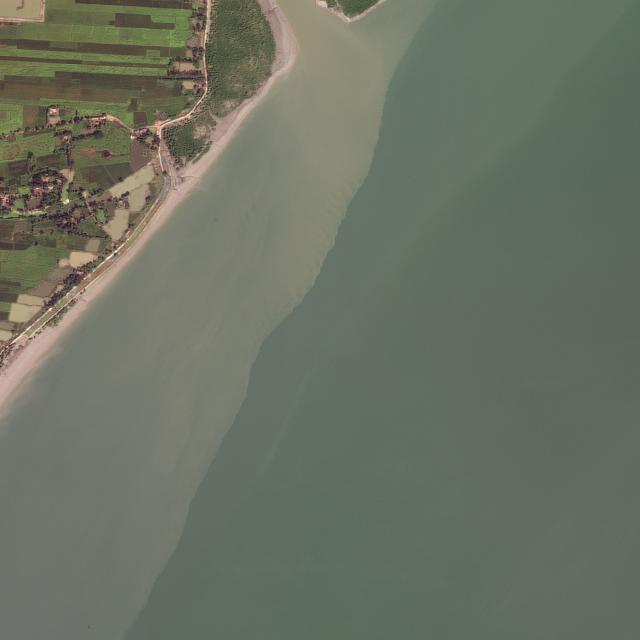

In [ ]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

In [ ]:
result = get_sliced_prediction(
    "satellite-image-segmentation-1/test/images/water_body_1029_jpg.rf.c32c4b7028db0a1fb014b2738e5ef4e6.jpg",
    detection_model_seg,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 9 slices.


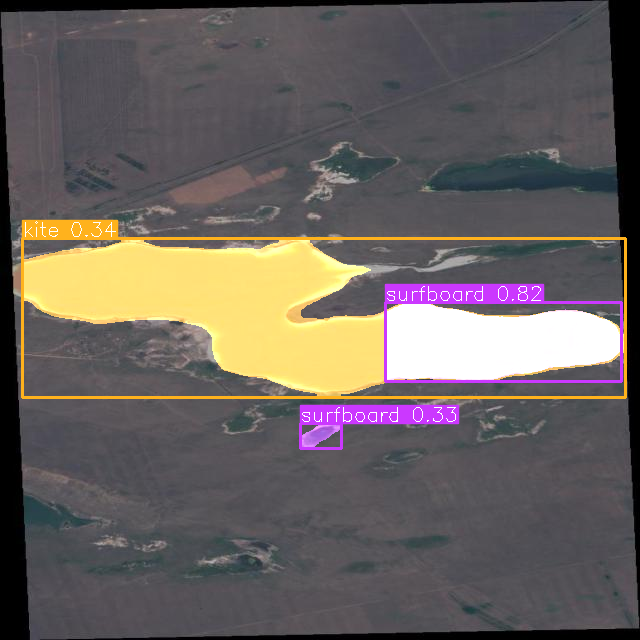

In [ ]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

In [ ]:
object_prediction_list = result.object_prediction_list
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(22, 238, 625, 397), w: 603, h: 159>,
    mask: <sahi.annotation.Mask object at 0x7caa1820c820>,
    score: PredictionScore: <value: 0.33676183223724365>,
    category: Category: <id: 33, name: kite>>

In [ ]:
object_prediction_list[0].mask.segmentation

[[121,
  238,
  121,
  241,
  120,
  242,
  119,
  242,
  118,
  243,
  115,
  243,
  114,
  244,
  112,
  244,
  111,
  245,
  109,
  245,
  108,
  246,
  106,
  246,
  105,
  247,
  97,
  247,
  96,
  248,
  74,
  248,
  73,
  249,
  70,
  249,
  69,
  250,
  62,
  250,
  61,
  251,
  58,
  251,
  57,
  252,
  55,
  252,
  54,
  253,
  49,
  253,
  48,
  254,
  44,
  254,
  43,
  255,
  40,
  255,
  39,
  256,
  36,
  256,
  35,
  257,
  33,
  257,
  32,
  258,
  29,
  258,
  28,
  259,
  22,
  259,
  22,
  300,
  27,
  300,
  28,
  301,
  29,
  301,
  30,
  302,
  31,
  302,
  37,
  308,
  38,
  308,
  39,
  309,
  40,
  309,
  42,
  311,
  43,
  311,
  44,
  312,
  46,
  312,
  47,
  313,
  48,
  313,
  49,
  314,
  50,
  314,
  51,
  315,
  53,
  315,
  54,
  316,
  58,
  316,
  59,
  317,
  64,
  317,
  65,
  318,
  71,
  318,
  72,
  319,
  79,
  319,
  80,
  320,
  85,
  320,
  86,
  321,
  89,
  321,
  90,
  322,
  92,
  322,
  93,
  323,
  106,
  323,
  107,
  322,
  114,
  3

Sliced predictions are much better

In [ ]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 3 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/3 [00:00<?, ?it/s]

Performing prediction on 15 slices.


Performing inference on images:  33%|███▎      | 1/3 [00:05<00:11,  5.72s/it]

Prediction time is: 5662.06 ms
Performing prediction on 20 slices.


Performing inference on images:  67%|██████▋   | 2/3 [00:13<00:07,  7.02s/it]

Prediction time is: 7860.75 ms
Performing prediction on 9 slices.


Performing inference on images: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]

Prediction time is: 3281.17 ms
Prediction results are successfully exported to runs/predict/exp3
